# Scenario 2: SIDARTHE model
This model is already annotated as a biomodels model (model BIOMD0000000955) and can be found here:
https://www.ebi.ac.uk/biomodels/BIOMD0000000955

In [1]:
from IPython.display import Image
from mira.sources.biomodels import get_template_model
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file
from mira.modeling.viz import GraphicalModel
from mira.examples.concepts import vaccinated
# Compare the models to see the difference
from mira.dkg.web_client import is_ontological_child_web

In [2]:
# Get the model
sidarthe = get_template_model('BIOMD0000000955')

In [3]:
print(sidarthe.templates[0].rate_law.args[0])

Susceptible*(Ailing*gamma + Diagnosed*beta + Infected*alpha + Recognized*delta)


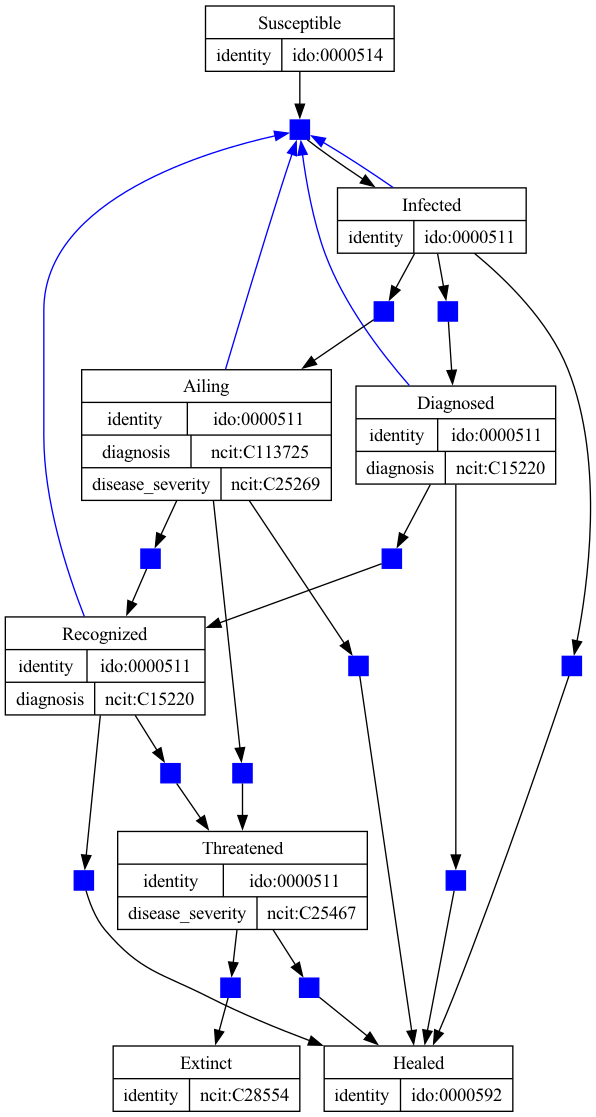

In [4]:
GraphicalModel.for_jupyter(sidarthe, name='eval_202301_scenario2_sidarthe.png')

### Simplify model to break up group control

In [5]:
from mira.metamodel.ops import simplify_rate_laws
sidarthe = simplify_rate_laws(sidarthe)

In [6]:
for template in sidarthe.templates[:4]:
    print(template.rate_law)

Diagnosed*Susceptible*beta
Ailing*Susceptible*gamma
Recognized*Susceptible*delta
Infected*Susceptible*alpha


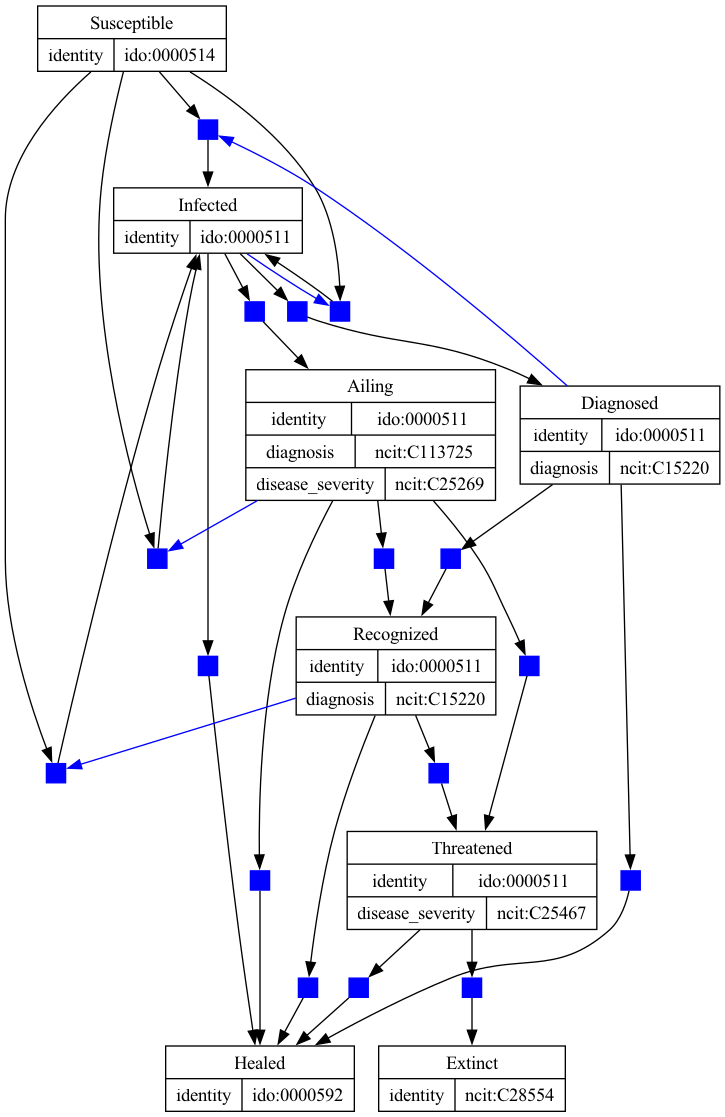

In [7]:
GraphicalModel.for_jupyter(sidarthe, name='eval_202301_scenario2_sidarthe_simplified.png')

In [8]:
template_model_to_petrinet_json_file(sidarthe, 'eval_202301_scenario2_sidarthe_petrinet.json')

In [9]:
model_to_json_file(sidarthe, 'eval_202301_scenario2_sidarthe_mira.json')

In [10]:
sidarthe.parameters

{'alpha': Parameter(name='alpha', display_name=None, description='alpha', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.57, distribution=None),
 'beta': Parameter(name='beta', display_name=None, description='beta', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.011, distribution=None),
 'gamma': Parameter(name='gamma', display_name=None, description='gamma', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.456, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description='delta', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.011, distribution=None),
 'epsilon': Parameter(name='epsilon', display_name=None, description='epsilon', identifiers={}, context={}, units=Unit(expression=1/day), value=0.171, distribution=None),
 'theta': Parameter(name='theta', display_name=None, description='theta', identifiers={}, context={}, units=Unit(expression=1/day), value

## Add vaccination
According to the scenario description, vaccination is added to the model and is described in this Nature paper: [https://www.nature.com/articles/s41591-021-01334-5](https://www.nature.com/articles/s41591-021-01334-5), see the graphics of the model here: [https://www.nature.com/articles/s41591-021-01334-5/figures/1](https://www.nature.com/articles/s41591-021-01334-5/figures/1)
The vaccination is added as immunizing vaccination, meaning when someone is vaccinated in this model, they are converted to an end-state in the model where they are no longer susceptible to infection.

In [11]:
# Create a new model with vaccination by adding the vaccination process to the existing model
susceptible = sidarthe.get_concepts_by_name('Susceptible')[0]
vaccination = NaturalConversion(
    subject=susceptible,
    outcome=vaccinated)
sidarthe_v = sidarthe.add_template(vaccination)
sidarthe_v.parameters['phi'] = Parameter(name="phi", value=0)
vaccination.set_mass_action_rate_law("phi")

### Modify model according to SIDARTHE/SIDARTHE-V differences

In [12]:
# Modify other rate laws to correspond to the equations in the paper
# Specifically:
# 1. there is now a direct link from R to E with rate tau_2
# 2. the rate for T to E is now tau_1 (changed from just tau)

# 1. Create the new transition
recognized = sidarthe.get_concepts_by_name('Recognized')[0]
extinct = sidarthe.get_concepts_by_name('Extinct')[0]
recognized_to_death = NaturalConversion(
    subject=recognized,
    outcome=extinct)
recognized_to_death.set_mass_action_rate_law("tau_1")
sidarthe_v.parameters['tau_1'] = Parameter(name="tau_1", value=0.00333)
sidarthe_v = sidarthe_v.add_template(recognized_to_death)

# 2. Modify the rate law for T to E and remove the old parameter name from the parameters dict
T_E_transition = sidarthe_v.templates[14]
T_E_transition.rate_law = T_E_transition.rate_law.subs('tau', 'tau_2')
sidarthe_v.parameters['tau_2'] = Parameter(name="tau_2", value=0.01)
sidarthe_v.parameters.pop('tau')

Parameter(name='tau', display_name=None, description='tau', identifiers={}, context={}, units=Unit(expression=1/day), value=0.01, distribution=None)

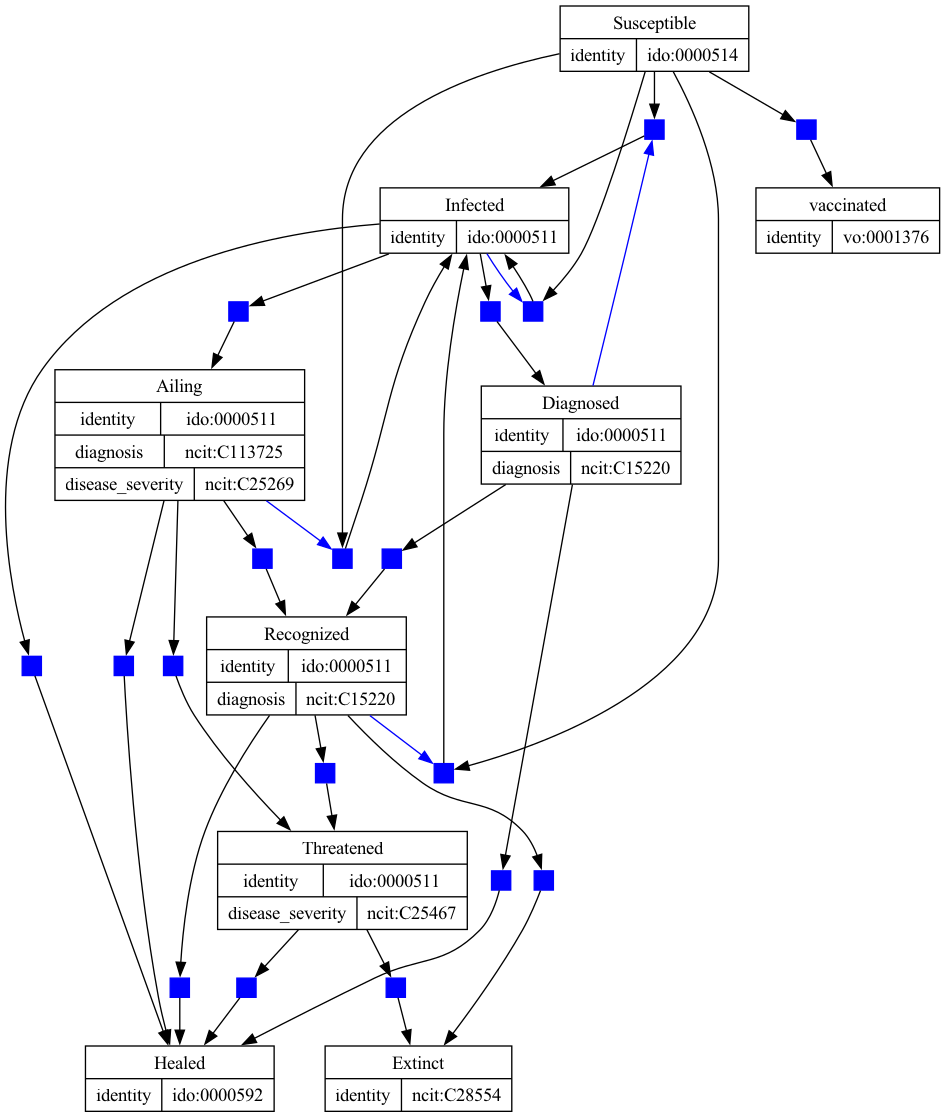

In [13]:
GraphicalModel.for_jupyter(sidarthe_v, name='eval_202301_scenario2_sidarthe_v.png')

### Compare the two models to find differences

In [14]:
tmd = TemplateModelDelta(sidarthe, sidarthe_v, refinement_function=is_ontological_child_web)

In [ ]:
tmd.draw_graph("eval_202301_scenario2_sidarthe_v_diff.png", args="-Grankdir=TB")
Image("eval_202301_scenario2_sidarthe_v_diff.png")

In [ ]:
# Export to Petrinet
template_model_to_petrinet_json_file(sidarthe_v, 'eval_202301_scenario2_sidarthe_v_petrinet.json')

In [17]:
model_to_json_file(sidarthe_v, 'eval_202301_scenario2_sidarthe_v_mira.json')

In [18]:
sidarthe_v.parameters

{'alpha': Parameter(name='alpha', display_name=None, description='alpha', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.57, distribution=None),
 'beta': Parameter(name='beta', display_name=None, description='beta', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.011, distribution=None),
 'gamma': Parameter(name='gamma', display_name=None, description='gamma', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.456, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description='delta', identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.011, distribution=None),
 'epsilon': Parameter(name='epsilon', display_name=None, description='epsilon', identifiers={}, context={}, units=Unit(expression=1/day), value=0.171, distribution=None),
 'theta': Parameter(name='theta', display_name=None, description='theta', identifiers={}, context={}, units=Unit(expression=1/day), value

In [19]:
from mira.metamodel import TemplateModelComparison
tc = TemplateModelComparison([sidarthe, sidarthe_v], refinement_func=is_ontological_child_web)

Comparing model templates: 561it [00:28, 19.47it/s]
Comparing model concepts: 136it [00:15,  8.62it/s]


In [20]:
print(tc.model_comparison.get_similarity_scores())

[{'models': (0, 1), 'score': 0.8888888888888888}]


In [21]:
with open('eval_202301_scenario2_sidarthe_v_model_comparison.json', 'w') as fh:
    fh.write(tc.model_comparison.model_dump_json(indent=1))